In [1]:
import random as rd
import sys
import copy
import pickle


In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model
import code

In [6]:
ddir   = '/scratch/tdunstan/ml_data/ga7/pickles_keras_v3/'
#ddir_out = '/scratch/tdunstan/ml_data/ga7/pickles_keras_v3/models/'

wl='sw'

target='nflx'

nsamps = '50.0K'
#nsamps = '100.0K'
#nsamps = '200.0K'
#nsamps = '500.0K'
#nsamps = '1000.0K'

scale_data = True

if wl=='sw':
  model = 'sw_260'
  model_ref = 'sw_ga7'

if wl=='lw':
  model = 'lw_300'
  model_ref = 'lw_ga7'
#ddir_out = '/scratch/tdunstan/ml_data/ga7/pickles_keras_v3/models/'

wl='sw'

target='nflx'

nsamps = '50.0K'
#nsamps = '100.0K'
#nsamps = '200.0K'
#nsamps = '500.0K'
#nsamps = '1000.0K'

scale_data = True

if wl=='sw':
  model = 'sw_260'
  model_ref = 'sw_ga7'

if wl=='lw':
  model = 'lw_300'
  model_ref = 'lw_ga7'

In [7]:
fnext='train'
fn_meta = model+'_meta_'+nsamps+'_'+fnext+'.npz'
fn_dat_levs = model+'_dat_levs_'+nsamps+'_'+fnext+'.npz'
fn_dat_lays = model+'_dat_lays_'+nsamps+'_'+fnext+'.npz'
fn_dat_surf = model+'_dat_surf_'+nsamps+'_'+fnext+'.npz'
if target=='nflx':
  fn_trg = model+'_trg_levs_'+nsamps+'_'+fnext+'.npz'
if target=='ndiv':
  fn_trg = model+'_trg_lays_'+nsamps+'_'+fnext+'.npz'
 
fnext='test'
fn_meta_test = model+'_meta_'+nsamps+'_'+fnext+'.npz'
fn_dat_levs_test = model+'_dat_levs_'+nsamps+'_'+fnext+'.npz'
fn_dat_lays_test = model+'_dat_lays_'+nsamps+'_'+fnext+'.npz'
fn_dat_surf_test = model+'_dat_surf_'+nsamps+'_'+fnext+'.npz'
if target=='nflx':
  fn_trg_test = model+'_trg_levs_'+nsamps+'_'+fnext+'.npz'
  fn_trg_ref = model_ref+'_trg_levs_'+nsamps+'_'+fnext+'.npz'
if target=='ndiv':
  fn_trg_test = model+'_trg_lays_'+nsamps+'_'+fnext+'.npz'
  fn_trg_ref = model_ref+'_trg_lays_'+nsamps+'_'+fnext+'.npz'

print('root dir:',ddir)

root dir: /scratch/tdunstan/ml_data/ga7/pickles_keras_v3/


In [8]:
print('loading',fn_dat_lays)
npzfile = np.load(ddir+fn_dat_lays)
dat_lays = npzfile['dat_lays']
npzfile.close()


loading sw_260_dat_lays_50.0K_train.npz


In [9]:
print('loading',fn_dat_surf)
npzfile = np.load(ddir+fn_dat_surf)
dat_surf = npzfile['dat_surf']
npzfile.close()

loading sw_260_dat_surf_50.0K_train.npz


In [10]:
print('loading',fn_trg)
npzfile = np.load(ddir+fn_trg)
if target=='nflx':
 trg = npzfile['trg_levs']
if target=='ndiv':
 trg = npzfile['trg_lays']
npzfile.close()


loading sw_260_trg_levs_50.0K_train.npz


In [11]:
nsamps = trg.shape[0]
nlays = dat_lays.shape[1]
nlay_feats = dat_lays.shape[2]
nsurf_feats = dat_surf.shape[1]

In [12]:
if scale_data: # normalize by range
  scaler_lays = []
  use_lays = []
  for ic in range(nlay_feats):
    min0 = np.min(dat_lays[:,:,ic])
    range0 = np.max(dat_lays[:,:,ic]) - min0
    if range0 > 0.:
      dat_lays[:,:,ic] = (dat_lays[:,:,ic] - min0)/range0
      scaler_lays.append([min0, range0])
      use_lays.append(ic)
  if len(use_lays)<nlay_feats:
    print('removing constant layer features:', nlay_feats-len(use_lays))
    dat_lays = dat_lays[:,:,use_lays]
    nlay_feats = len(use_lays)
      

  scaler_surf = []
  use_surf = []
  for ic in range(nsurf_feats):
    min0 = np.min(dat_surf[:,ic])
    range0 = np.max(dat_surf[:,ic]) - min0
    if range0 > 0.:
      dat_surf[:,ic] = (dat_surf[:,ic] - min0)/range0
      scaler_surf.append([min0, range0])
      use_surf.append(ic)
  if len(use_surf)<nsurf_feats:
    print('removing constant surf features:', nsurf_feats-len(use_surf))
    dat_surf = dat_surf[:,:,use_surf]
    nsurf_feats = len(use_surf)



removing constant layer features: 6


In [14]:
ntrg_samps = trg.shape[0]

if target=='nflx' or target=='ndiv':
  nouts=1
  ntrg_levs = trg.shape[1]


In [15]:
profile_input = Input(shape=(nlays, nlay_feats), name='profile_input')
surf_input = Input(shape=(nsurf_feats,), name='surf_input')
flat_profs = Flatten()(profile_input)
raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
raw_size = (nlays*nlay_feats)+nsurf_feats
prof_size = nlays*nlay_feats

x = Dense(512, use_bias=False, activation='relu')(raw_in)
x = Dense(512, use_bias=False, activation='relu')(x)
x = Dense(256, use_bias=False, activation='relu')(x)
x = Dense(256, use_bias=False, activation='relu')(x)
x = Dense(128, use_bias=False, activation='relu')(x)
x = Dense(128, use_bias=False, activation='relu')(x)

main_output = Dense(ntrg_levs, use_bias=True, activation='linear', name='main_output')(x)
model = Model(inputs=[profile_input, surf_input], outputs=[main_output])

In [16]:


model.compile(loss='mean_absolute_error', optimizer='adam')


In [17]:

model.fit([dat_lays, dat_surf], trg, epochs=1, batch_size=32, verbose=0)

In [18]:
del dat_lays, dat_surf


In [19]:

# load test data
print('loading',fn_dat_lays_test)
npzfile = np.load(ddir+fn_dat_lays_test)
dat_lays_test = npzfile['dat_lays']
npzfile.close()

print('loading',fn_dat_surf_test)
npzfile = np.load(ddir+fn_dat_surf_test)
dat_surf_test = npzfile['dat_surf']
npzfile.close()

print('loading',fn_trg_test)
npzfile = np.load(ddir+fn_trg_test)
if target=='nflx':
 trg_test = npzfile['trg_levs']
if target=='ndiv':
 trg_test = npzfile['trg_lays']
npzfile.close()

print('loading',fn_trg_ref)
npzfile = np.load(ddir+fn_trg_ref)
if target=='nflx':
 trg_ref = npzfile['trg_levs_ref']
if target=='ndiv':
 trg_ref = npzfile['trg_lays_ref']
npzfile.close()


loading sw_260_dat_lays_50.0K_test.npz
loading sw_260_dat_surf_50.0K_test.npz
loading sw_260_trg_levs_50.0K_test.npz
loading sw_ga7_trg_levs_50.0K_test.npz


In [20]:
# scale test data
if scale_data: # normalize by range
  dat_lays_test = dat_lays_test[:,:,use_lays]
  for ic in range(nlay_feats):
    dat_lays_test[:,:,ic] = (dat_lays_test[:,:,ic] - scaler_lays[ic][0])/scaler_lays[ic][1]

  dat_surf_test = dat_surf_test[:,use_surf]
  for ic in range(nsurf_feats):
    dat_surf_test[:,ic] = (dat_surf_test[:,ic] - scaler_surf[ic][0])/scaler_surf[ic][1]



In [21]:
p = model.predict([dat_lays_test, dat_surf_test])

In [22]:

me_p = np.zeros(ntrg_levs)
me_ctl = np.zeros(ntrg_levs)
mae_p = np.zeros(ntrg_levs)
mae_ctl = np.zeros(ntrg_levs)


In [23]:

for ilev in range(ntrg_levs):
  me_p[ilev] = np.mean(p[:,ilev] - trg_test[:,ilev])
  me_ctl[ilev] = np.mean(trg_ref[:,ilev] - trg_test[:,ilev])
  mae_p[ilev] = np.mean(np.abs(p[:,ilev] - trg_test[:,ilev]))
  mae_ctl[ilev] = np.mean(np.abs(trg_ref[:,ilev] - trg_test[:,ilev]))


In [25]:
yax = np.arange(1,len(me_p[1:])+1)[::-1]


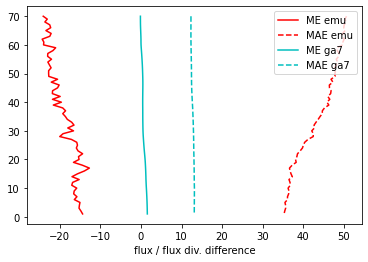

In [26]:
plt.plot(me_p[1:],yax, '-r', label='ME emu')
plt.plot(mae_p[1:],yax, '--r', label='MAE emu')
plt.plot(me_ctl[1:],yax, '-c', label='ME ga7')
plt.plot(mae_ctl[1:],yax, '--c', label='MAE ga7')
plt.xlabel('level')
plt.xlabel('flux / flux div. difference')
plt.legend(loc='upper right')

plt.show()


In [27]:
#model.save(out_pkl_fname1)
#
#f = open(out_pkl_fname2,'wb')
#pickle.dump(me_p,f)
#pickle.dump(mae_p,f)
#pickle.dump(me_ctl,f)
#pickle.dump(mae_ctl,f)
#f.close()
#
#f = open(out_pkl_fname3,'wb')
#pickle.dump(scaler_lays,f)
#pickle.dump(scaler_surf,f)
#pickle.dump(use_lays,f)
#pickle.dump(use_surf,f)
#f.close()
#